In [41]:
# Run this again after editing submodules so Colab uses the updated versions
import os
import pickle
import time
from pathlib import Path
import matplotlib.pyplot as plt
from agents.marlisa import MARLISA
from citylearn import  CityLearn
from ornl.citylearn_madmeub.utilities import read_json

In [36]:
# Load environment
climate_zone = 2
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes_filename = 'building_attributes.json'
building_attributes = read_json(os.path.join(data_path,building_attributes_filename))
building_ids = [key for key in building_attributes.keys() if 'madmeub_' in key]
params = {
    'data_path':data_path, 
    'building_attributes':building_attributes_filename, 
    'weather_file':'weather_data.csv', 
    'solar_profile':'solar_generation_1kW.csv', 
    'carbon_intensity':'carbon_intensity.csv',
    'building_ids':building_ids,
    'buildings_states_actions':'buildings_state_action_space.json', 
    'simulation_period':(0, 8760-1), 
    'cost_function':[
        'ramping',
        '1-load_factor',
        'average_daily_peak',
        'peak_demand',
        'net_electricity_consumption',
        'carbon_emissions'
    ], 
    'central_agent':False,
    'save_memory':False
}

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
# Can be obtained using observations_spaces[i].low or .high
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

# Instantiating the control agent(s)
params_agent = {
    'building_ids':building_ids,
    'buildings_states_actions':'buildings_state_action_space.json', 
    'building_info':building_info,
    'observation_spaces':observations_spaces, 
    'action_spaces':actions_spaces, 
    'hidden_dim':[256,256], 
    'discount':0.99, 
    'tau':5e-3, 
    'lr':3e-4, 
    'batch_size':256, 
    'replay_buffer_capacity':1e5, 
    'regression_buffer_capacity':3e4, 
    'start_training':600, # Start updating actor-critic networks
    'exploration_period':7500, # Just taking random actions
    'start_regression':500, # Start training the regression model
    'information_sharing':True, # If True -> set the appropriate 'reward_function_ma' in reward_function.py
    'pca_compression':.95, 
    'action_scaling_coef':0.5, # Actions are multiplied by this factor to prevent too aggressive actions
    'reward_scaling':5., # Rewards are normalized and multiplied by this factor
    'update_per_step':2, # How many times the actor-critic networks are updated every hourly time-step
    'iterations_as':2,# Iterations of the iterative action selection (see MARLISA paper for more info)
    'safe_exploration':True
} 
agents = MARLISA(**params_agent)

# We will use 1 episode if we intend to simulate a real-time RL controller (like in the CityLearn Challenge)
# In climate zone 5, 1 episode contains 5 years of data, or 8760*5 time-steps.
n_episodes = 1
start = time.time()

for e in range(n_episodes): 
    state = env.reset()
    done = False
    j = 0
    is_evaluating = False
    action, coordination_vars = agents.select_action(state, deterministic=is_evaluating)    
    
    while not done:
        next_state, reward, done, _ = env.step(action)
        action_next, coordination_vars_next = agents.select_action(next_state, deterministic=is_evaluating)
        agents.add_to_buffer(state, action, reward, next_state, done, coordination_vars, coordination_vars_next)
        coordination_vars = coordination_vars_next
        state = next_state
        action = action_next
        is_evaluating = (j > 3*8760)
        j += 1
        
    print('Loss -',env.cost(), 'Simulation time (min) -',(time.time()-start)/60.0)

cpu
Loss - {'ramping': 0.9878557, '1-load_factor': 1.0022111873375097, 'average_daily_peak': 0.9842221, 'peak_demand': 1.0, 'net_electricity_consumption': 0.9791197, 'carbon_emissions': 0.9818831, 'total': 0.9892153001584397, 'coordination_score': 0.9935722435649912} Simulation time (min) - 258.80442419846855


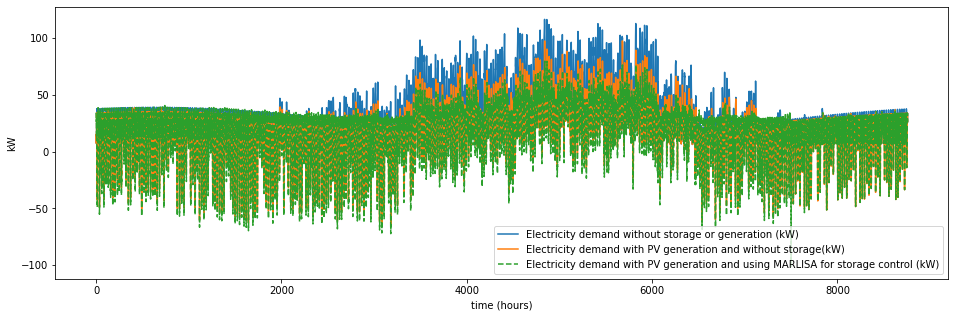

In [37]:
sim_period = (0, 8760-1)
interval = range(sim_period[0], sim_period[1])
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 
            'Electricity demand with PV generation and without storage(kW)', 
            'Electricity demand with PV generation and using MARLISA for storage control (kW)'])

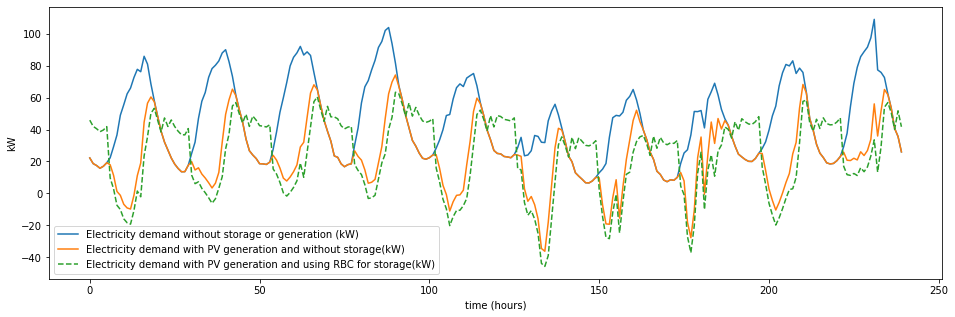

In [38]:
# Plotting summer operation in the last year
interval = range(24*30*6, 24*30*6 + + 24*10)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 
            'Electricity demand with PV generation and without storage(kW)', 
            'Electricity demand with PV generation and using RBC for storage(kW)'])

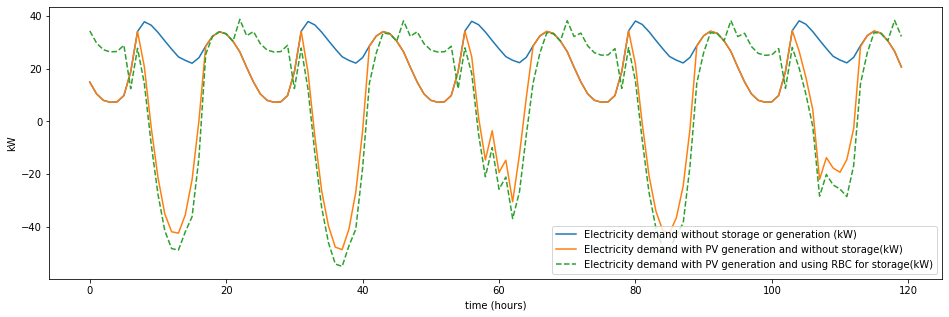

In [39]:
# Plotting 5 days of winter operation of the last year
plt.figure(figsize=(16,5))
interval = range(0, 24*5)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 
            'Electricity demand with PV generation and without storage(kW)', 
            'Electricity demand with PV generation and using RBC for storage(kW)'])

In [43]:
# with open('citylearn_env','wb') as f:
#     pickle.dump(env,f)


In [44]:
# with open('citylearn_env','rb') as f:
#     asv = pickle.load(f)